<a href="https://colab.research.google.com/github/shreyashrawat/Cifa10_Generator/blob/master/Digits_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.datasets.mnist import load_data

In [0]:
def load_dataset():
    (X_train, _), (_, _) = load_data()
    X_train = X_train.astype("float32")
    X_train = X_train/255.0
    return X_train

In [0]:
(X_train, _), (_, _) = load_data()

In [0]:
def get_real_samples(dataset, size):
    ind = np.random.randint(0, len(dataset), size)
    data = dataset[ind]
    data = np.expand_dims(data, -1)
    y = np.ones(shape = (size, 1))
    return data, y

In [0]:
def discriminator(input_shape = (28,28,1)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides = (2,2), padding = "same", input_shape = input_shape),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.3),
        
        # tf.keras.layers.Conv2D(64, 3, strides = (2,2), padding = "same"),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.LeakyReLU(0.2),
        # tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, strides = (2,2), padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.02),
        tf.keras.layers.Dropout(0.3),
        
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, "sigmoid")
    ])
    optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ['acc'])
    return model

In [0]:
def generate_fake_examples(n_samples):
    fake_samples = np.random.uniform(size = (n_samples , 28*28))
    fake_samples = -1 + fake_samples * 2
    fake_samples = fake_samples.reshape(n_samples, 28,28,1)
    y = np.zeros(shape = (n_samples, 1))
    return fake_samples,y

### Training Discrimantor seperately to check 

In [0]:
dataset = load_dataset()

In [0]:
# for i in range(20):
#     x_real, y_real = get_real_samples(dataset, 64)
#     loss_r,acc_r = d_model.train_on_batch(x_real, y_real)
#     x_fake, y_fake = generate_fake_examples(64)
#     loss_f, acc_f = d_model.train_on_batch(x_fake, y_fake)
#     print("Batch {}: Real acc: {} and Fake acc: {}".format(i+1, acc_r*100, acc_f* 100))
    

## Generator Upstacking 

In [0]:
def generate_latent_space(n_samples, latent_dim=100):
    x = np.random.randn(latent_dim * n_samples)
    x = x.reshape((n_samples, latent_dim))
    return x

In [0]:
def generator(latent_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128 * 7 * 7, input_dim = latent_dim),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Reshape((7, 7, 128)),
        
        tf.keras.layers.Conv2DTranspose(128, 4, strides = (2,2), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2DTranspose(128, 4, strides = (2,2), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2D(1, (7,7), padding="same", activation = "sigmoid")
    ])
    return model

In [0]:
g_model = generator(100)

In [30]:
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)      

In [0]:
def gan(g_model,d_model ):
    d_model.trainable = False
    model = tf.keras.models.Sequential([
        g_model,
        d_model
    ])
    model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5))
    return model

In [0]:
def generate_fake_examples(g_model, n_size):
    latent_space = generate_latent_space(n_size)
    fake_samples = g_model.predict(latent_space)
    y = np.zeros(shape = (n_size,1))
    return fake_samples, y

In [0]:
def generate_plot(dataset):
  plt.figure(figsize = (15,15))
  dataset = np.squeeze(dataset, -1)
  for i in range(7*7):
    plt.subplot(7,7,i+1)
    plt.axis("off")
    plt.imshow(dataset[i], cmap = "gray_r")
  plt.show()

In [0]:
def summarize_performance(d_model, g_model, n_samples, dataset):
  x_real, y_real = get_real_samples(dataset, n_samples)
  _, acc_r = d_model.evaluate(x_real, y_real)
  x_fake, y_fake = generate_fake_examples(g_model, n_samples)
  _, acc_f = d_model.evaluate(x_fake, y_fake)
  print("Real_example_Acc: {}, Fake_example_Acc: {}", acc_r*100, acc_f*100)
  generate_plot(x_fake) 

In [0]:
def train_gan( d_model, g_model, gan_model,dataset, batch_size, epochs = 50, latent_dim = 100):
    for i in range(epochs):
        for j in range(int(len(dataset)/batch_size)):
            x_real, y_real = get_real_samples(dataset, int(batch_size/2))
            
            x_fake, y_fake = generate_fake_examples(g_model, int(batch_size/2))
            x,y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            d_loss, d_acc = d_model.train_on_batch(x, y)
            x_gan = generate_latent_space(batch_size)
            y_gan = np.ones((batch_size,1))
            gan_loss = gan_model.train_on_batch(x_gan, y_gan)
            if ( (j+1)%50 == 0):
              print("Epoch {}: Step {}/{} >> D_LOSS : {} >> G_LOSS: {}".format(i+1, j+1, int(len(dataset)/batch_size), d_loss, gan_loss))
        if((i+1) % 2 == 0):
            summarize_performance(d_model, g_model, batch_size, dataset)
            

In [0]:
d_model = discriminator()
g_model = generator(100)
gan_model = gan(g_model, d_model)

In [45]:
d_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)         

In [46]:
g_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 128)      

In [47]:
gan_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 28, 28, 1)         1165313   
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 40961     
Total params: 1,206,274
Trainable params: 1,164,801
Non-trainable params: 41,473
_________________________________________________________________


Epoch 1: Step 50/468 >> D_LOSS : 0.03422065079212189 >> G_LOSS: 0.5323021411895752
Epoch 1: Step 100/468 >> D_LOSS : 0.04906187206506729 >> G_LOSS: 0.3020842671394348
Epoch 1: Step 150/468 >> D_LOSS : 0.020162058994174004 >> G_LOSS: 0.10456757247447968
Epoch 1: Step 200/468 >> D_LOSS : 0.023496419191360474 >> G_LOSS: 0.03903357684612274
Epoch 1: Step 250/468 >> D_LOSS : 0.03058168850839138 >> G_LOSS: 0.029499195516109467
Epoch 1: Step 300/468 >> D_LOSS : 0.011032329872250557 >> G_LOSS: 0.0135062076151371
Epoch 1: Step 350/468 >> D_LOSS : 0.04014928266406059 >> G_LOSS: 0.0012782004196196795
Epoch 1: Step 400/468 >> D_LOSS : 0.5546591281890869 >> G_LOSS: 0.04573627561330795
Epoch 1: Step 450/468 >> D_LOSS : 0.8245658278465271 >> G_LOSS: 0.1607198715209961
Epoch 2: Step 50/468 >> D_LOSS : 0.7626074552536011 >> G_LOSS: 0.33973658084869385
Epoch 2: Step 100/468 >> D_LOSS : 0.6905474066734314 >> G_LOSS: 0.5700032114982605
Epoch 2: Step 150/468 >> D_LOSS : 0.816705584526062 >> G_LOSS: 0.65705

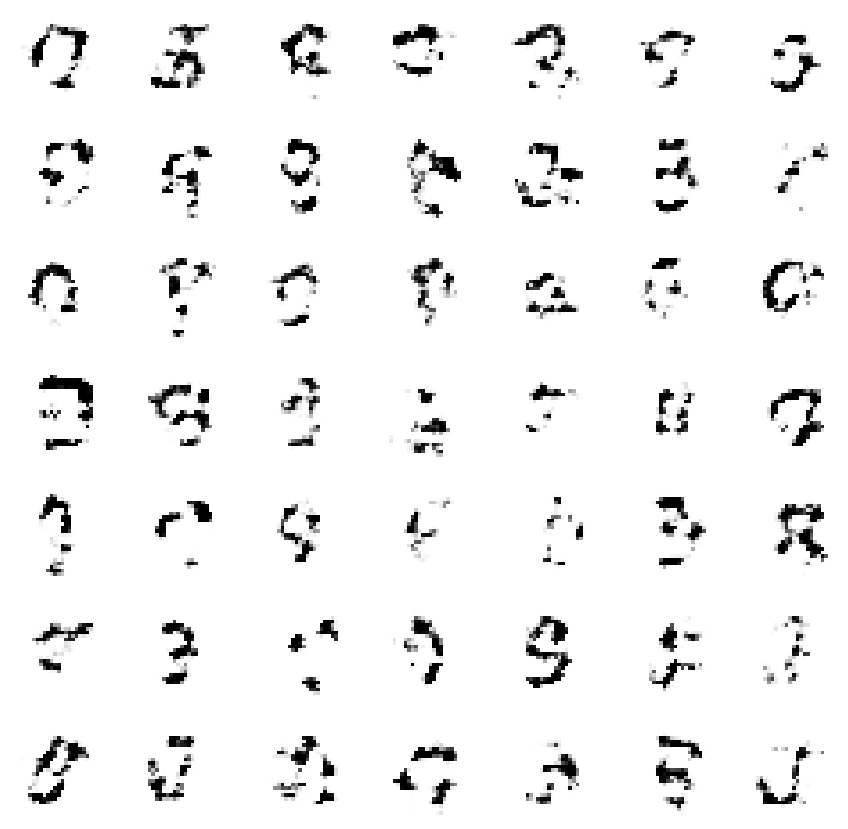

Epoch 3: Step 50/468 >> D_LOSS : 0.7045518159866333 >> G_LOSS: 0.8983071446418762
Epoch 3: Step 100/468 >> D_LOSS : 0.6987138986587524 >> G_LOSS: 0.9665136337280273
Epoch 3: Step 150/468 >> D_LOSS : 0.6372138857841492 >> G_LOSS: 0.8827705383300781
Epoch 3: Step 200/468 >> D_LOSS : 0.6547545194625854 >> G_LOSS: 1.1312596797943115
Epoch 3: Step 250/468 >> D_LOSS : 0.6927233338356018 >> G_LOSS: 0.9737997055053711
Epoch 3: Step 300/468 >> D_LOSS : 0.7835757732391357 >> G_LOSS: 1.0838453769683838
Epoch 3: Step 350/468 >> D_LOSS : 0.7135164737701416 >> G_LOSS: 1.070249080657959
Epoch 3: Step 400/468 >> D_LOSS : 0.6786577105522156 >> G_LOSS: 0.9888330698013306
Epoch 3: Step 450/468 >> D_LOSS : 0.7288331985473633 >> G_LOSS: 0.9527339935302734
Epoch 4: Step 50/468 >> D_LOSS : 0.678908109664917 >> G_LOSS: 0.958626925945282
Epoch 4: Step 100/468 >> D_LOSS : 0.6777893900871277 >> G_LOSS: 0.8911712765693665
Epoch 4: Step 150/468 >> D_LOSS : 0.7044422626495361 >> G_LOSS: 0.9614771604537964
Epoch 4: 

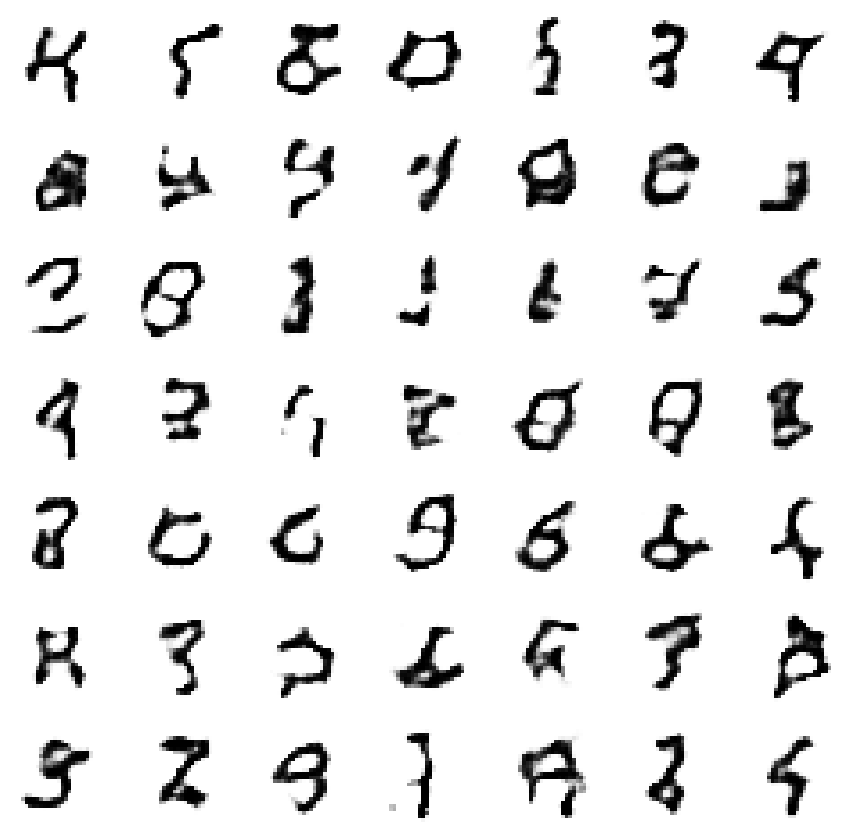

Epoch 5: Step 50/468 >> D_LOSS : 0.6937720775604248 >> G_LOSS: 0.8857809901237488
Epoch 5: Step 100/468 >> D_LOSS : 0.702979326248169 >> G_LOSS: 0.9470585584640503
Epoch 5: Step 150/468 >> D_LOSS : 0.6874991655349731 >> G_LOSS: 0.915690541267395
Epoch 5: Step 200/468 >> D_LOSS : 0.6992293000221252 >> G_LOSS: 0.8133642673492432
Epoch 5: Step 250/468 >> D_LOSS : 0.6880154013633728 >> G_LOSS: 0.8843125104904175
Epoch 5: Step 300/468 >> D_LOSS : 0.7114577293395996 >> G_LOSS: 0.8805956840515137
Epoch 5: Step 350/468 >> D_LOSS : 0.7094506621360779 >> G_LOSS: 0.7778463363647461
Epoch 5: Step 400/468 >> D_LOSS : 0.7063014507293701 >> G_LOSS: 0.837201714515686
Epoch 5: Step 450/468 >> D_LOSS : 0.6967417597770691 >> G_LOSS: 0.8088454008102417
Epoch 6: Step 50/468 >> D_LOSS : 0.6880308389663696 >> G_LOSS: 0.9226261377334595
Epoch 6: Step 100/468 >> D_LOSS : 0.6921850442886353 >> G_LOSS: 0.8216584324836731
Epoch 6: Step 150/468 >> D_LOSS : 0.6745483875274658 >> G_LOSS: 0.8848291635513306
Epoch 6: 

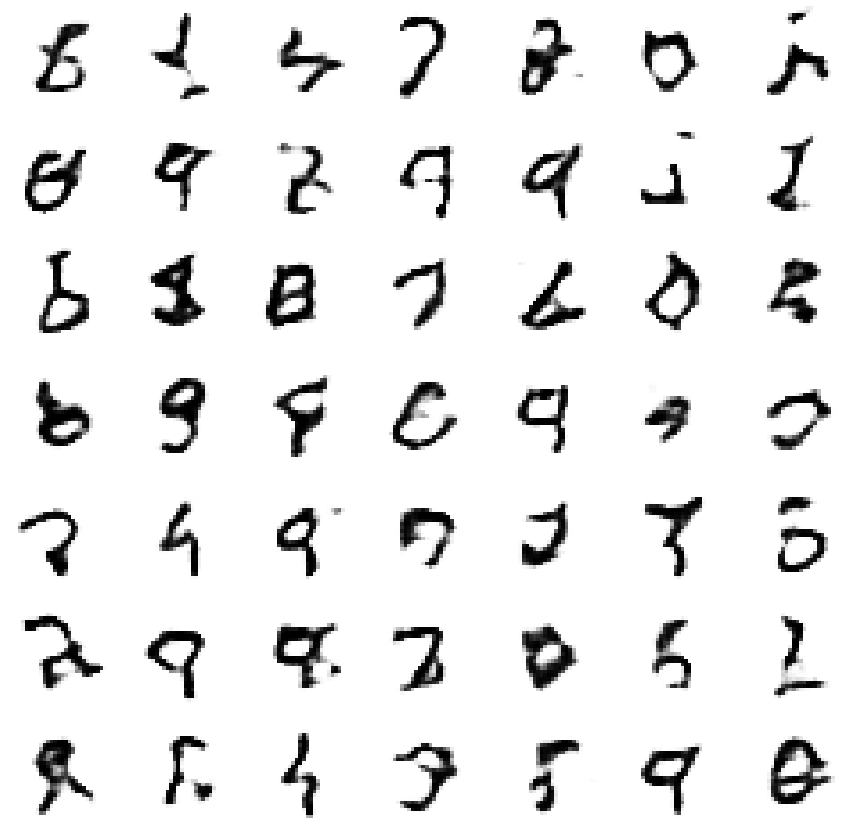

Epoch 7: Step 50/468 >> D_LOSS : 0.6780897378921509 >> G_LOSS: 0.9495007991790771
Epoch 7: Step 100/468 >> D_LOSS : 0.6902500987052917 >> G_LOSS: 0.7796282768249512
Epoch 7: Step 150/468 >> D_LOSS : 0.6580531597137451 >> G_LOSS: 0.7696410417556763
Epoch 7: Step 200/468 >> D_LOSS : 0.6916952729225159 >> G_LOSS: 0.8317911624908447
Epoch 7: Step 250/468 >> D_LOSS : 0.6800909638404846 >> G_LOSS: 0.6898372173309326
Epoch 7: Step 300/468 >> D_LOSS : 0.69941246509552 >> G_LOSS: 0.8043402433395386
Epoch 7: Step 350/468 >> D_LOSS : 0.6885290741920471 >> G_LOSS: 0.8349838852882385
Epoch 7: Step 400/468 >> D_LOSS : 0.689774215221405 >> G_LOSS: 0.7469345331192017
Epoch 7: Step 450/468 >> D_LOSS : 0.6699652075767517 >> G_LOSS: 0.7532650828361511
Epoch 8: Step 50/468 >> D_LOSS : 0.6720409393310547 >> G_LOSS: 0.8870809078216553
Epoch 8: Step 100/468 >> D_LOSS : 0.6620676517486572 >> G_LOSS: 0.931881308555603
Epoch 8: Step 150/468 >> D_LOSS : 0.6942075490951538 >> G_LOSS: 0.7855442762374878
Epoch 8: S

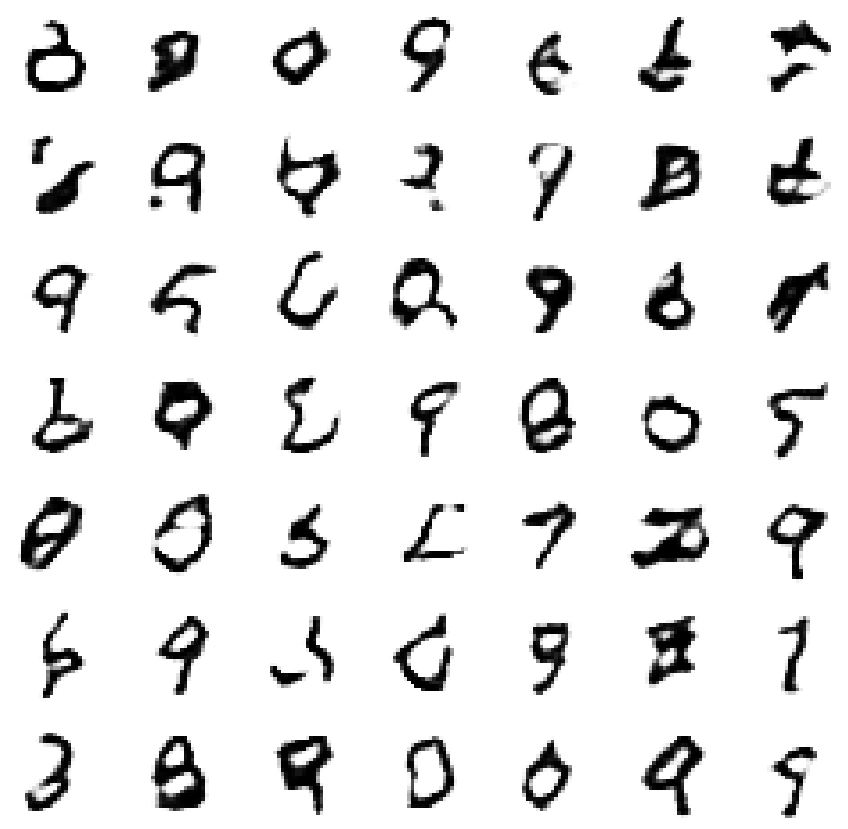

Epoch 9: Step 50/468 >> D_LOSS : 0.6896313428878784 >> G_LOSS: 0.8461108207702637
Epoch 9: Step 100/468 >> D_LOSS : 0.6976444721221924 >> G_LOSS: 0.8810861110687256
Epoch 9: Step 150/468 >> D_LOSS : 0.6544816493988037 >> G_LOSS: 0.7404370307922363
Epoch 9: Step 200/468 >> D_LOSS : 0.6488953232765198 >> G_LOSS: 0.8119761943817139
Epoch 9: Step 250/468 >> D_LOSS : 0.6840601563453674 >> G_LOSS: 0.8117660284042358
Epoch 9: Step 300/468 >> D_LOSS : 0.6633076667785645 >> G_LOSS: 0.8064042925834656
Epoch 9: Step 350/468 >> D_LOSS : 0.6310757398605347 >> G_LOSS: 0.9022136926651001
Epoch 9: Step 400/468 >> D_LOSS : 0.6689649224281311 >> G_LOSS: 0.9254117012023926
Epoch 9: Step 450/468 >> D_LOSS : 0.6709706783294678 >> G_LOSS: 0.7902801632881165
Epoch 10: Step 50/468 >> D_LOSS : 0.662321150302887 >> G_LOSS: 0.6788502931594849
Epoch 10: Step 100/468 >> D_LOSS : 0.6827847957611084 >> G_LOSS: 0.687706708908081
Epoch 10: Step 150/468 >> D_LOSS : 0.694725513458252 >> G_LOSS: 0.9503009915351868
Epoch 

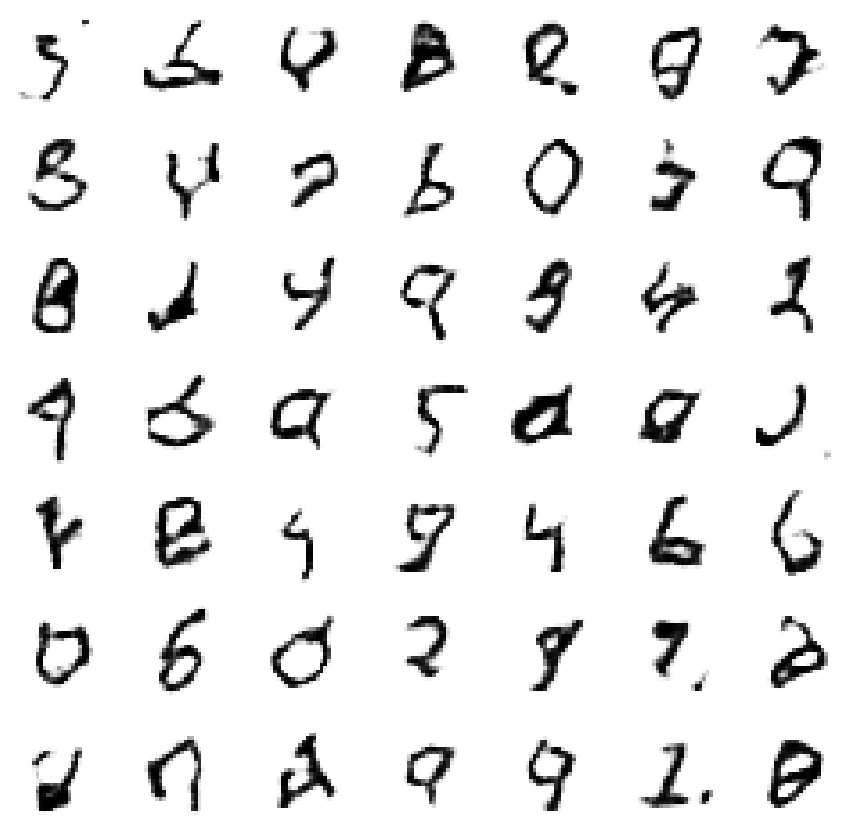

Epoch 11: Step 50/468 >> D_LOSS : 0.696220874786377 >> G_LOSS: 0.816230297088623
Epoch 11: Step 100/468 >> D_LOSS : 0.6539027690887451 >> G_LOSS: 0.6362833976745605
Epoch 11: Step 150/468 >> D_LOSS : 0.6884274482727051 >> G_LOSS: 0.9689871072769165
Epoch 11: Step 200/468 >> D_LOSS : 0.6667391061782837 >> G_LOSS: 0.6857646703720093
Epoch 11: Step 250/468 >> D_LOSS : 0.6415183544158936 >> G_LOSS: 0.7869128584861755
Epoch 11: Step 300/468 >> D_LOSS : 0.6622006893157959 >> G_LOSS: 0.8791670203208923
Epoch 11: Step 350/468 >> D_LOSS : 0.6643688678741455 >> G_LOSS: 1.0480328798294067
Epoch 11: Step 400/468 >> D_LOSS : 0.6753548383712769 >> G_LOSS: 0.8848329782485962
Epoch 11: Step 450/468 >> D_LOSS : 0.6383470892906189 >> G_LOSS: 0.9390971660614014
Epoch 12: Step 50/468 >> D_LOSS : 0.6611164808273315 >> G_LOSS: 0.8415068984031677
Epoch 12: Step 100/468 >> D_LOSS : 0.6523805856704712 >> G_LOSS: 0.7030043601989746
Epoch 12: Step 150/468 >> D_LOSS : 0.6602714657783508 >> G_LOSS: 0.8561885356903

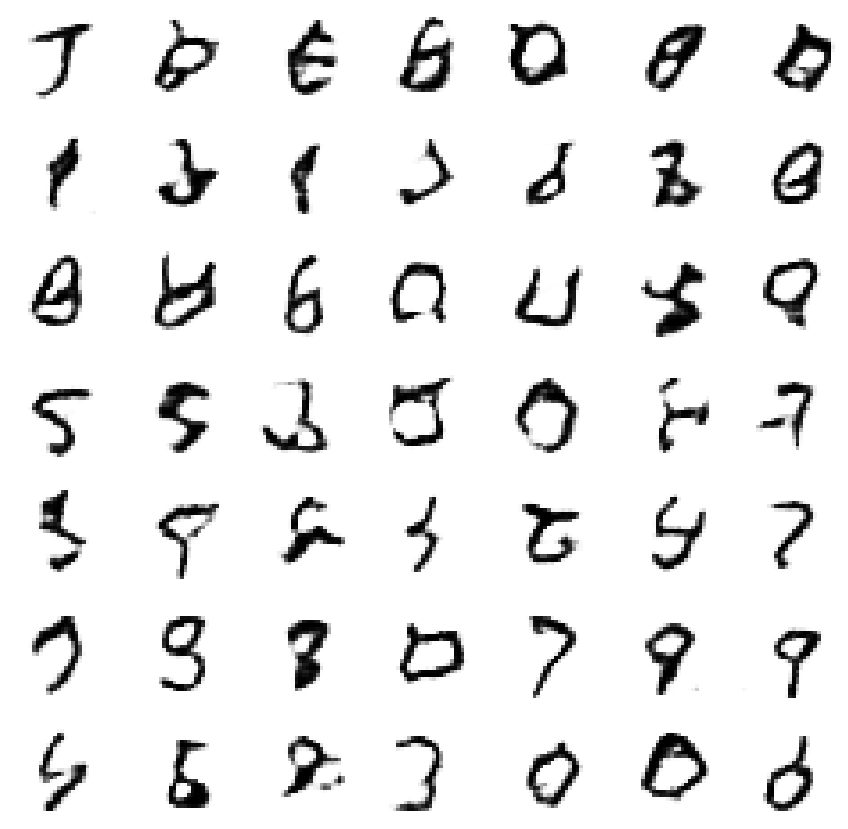

Epoch 13: Step 50/468 >> D_LOSS : 0.6431608200073242 >> G_LOSS: 0.7989904284477234
Epoch 13: Step 100/468 >> D_LOSS : 0.6416919231414795 >> G_LOSS: 0.9058699011802673
Epoch 13: Step 150/468 >> D_LOSS : 0.6508462429046631 >> G_LOSS: 0.7596991062164307
Epoch 13: Step 200/468 >> D_LOSS : 0.6389240026473999 >> G_LOSS: 0.9404441118240356
Epoch 13: Step 250/468 >> D_LOSS : 0.6497862339019775 >> G_LOSS: 0.7384270429611206
Epoch 13: Step 300/468 >> D_LOSS : 0.6739450693130493 >> G_LOSS: 0.6991561055183411
Epoch 13: Step 350/468 >> D_LOSS : 0.6805292367935181 >> G_LOSS: 0.7239606380462646
Epoch 13: Step 400/468 >> D_LOSS : 0.6702748537063599 >> G_LOSS: 0.8839337825775146
Epoch 13: Step 450/468 >> D_LOSS : 0.6493476033210754 >> G_LOSS: 0.6702467203140259
Epoch 14: Step 50/468 >> D_LOSS : 0.6590780019760132 >> G_LOSS: 1.2352529764175415
Epoch 14: Step 100/468 >> D_LOSS : 0.6268325448036194 >> G_LOSS: 0.8125795125961304
Epoch 14: Step 150/468 >> D_LOSS : 0.6714975833892822 >> G_LOSS: 1.00858759880

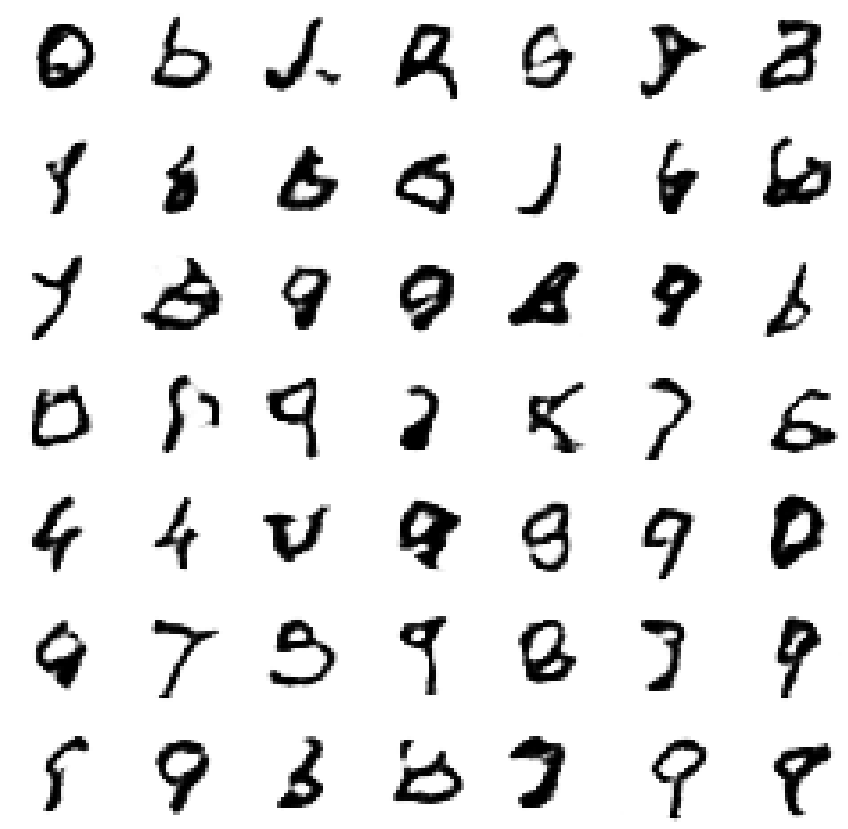

Epoch 15: Step 50/468 >> D_LOSS : 0.633975625038147 >> G_LOSS: 1.0264065265655518
Epoch 15: Step 100/468 >> D_LOSS : 0.6202282309532166 >> G_LOSS: 0.683952808380127
Epoch 15: Step 150/468 >> D_LOSS : 0.6599663496017456 >> G_LOSS: 0.720648467540741
Epoch 15: Step 200/468 >> D_LOSS : 0.6230003237724304 >> G_LOSS: 0.7404384613037109
Epoch 15: Step 250/468 >> D_LOSS : 0.6667801141738892 >> G_LOSS: 0.9843276143074036
Epoch 15: Step 300/468 >> D_LOSS : 0.6437914371490479 >> G_LOSS: 0.6672901511192322
Epoch 15: Step 350/468 >> D_LOSS : 0.6592086553573608 >> G_LOSS: 0.9620956778526306
Epoch 15: Step 400/468 >> D_LOSS : 0.6956279277801514 >> G_LOSS: 0.8677473068237305
Epoch 15: Step 450/468 >> D_LOSS : 0.6362470388412476 >> G_LOSS: 0.830389142036438
Epoch 16: Step 50/468 >> D_LOSS : 0.6857982873916626 >> G_LOSS: 0.7955135107040405
Epoch 16: Step 100/468 >> D_LOSS : 0.6662958264350891 >> G_LOSS: 0.851123571395874
Epoch 16: Step 150/468 >> D_LOSS : 0.5965378284454346 >> G_LOSS: 1.261474370956421


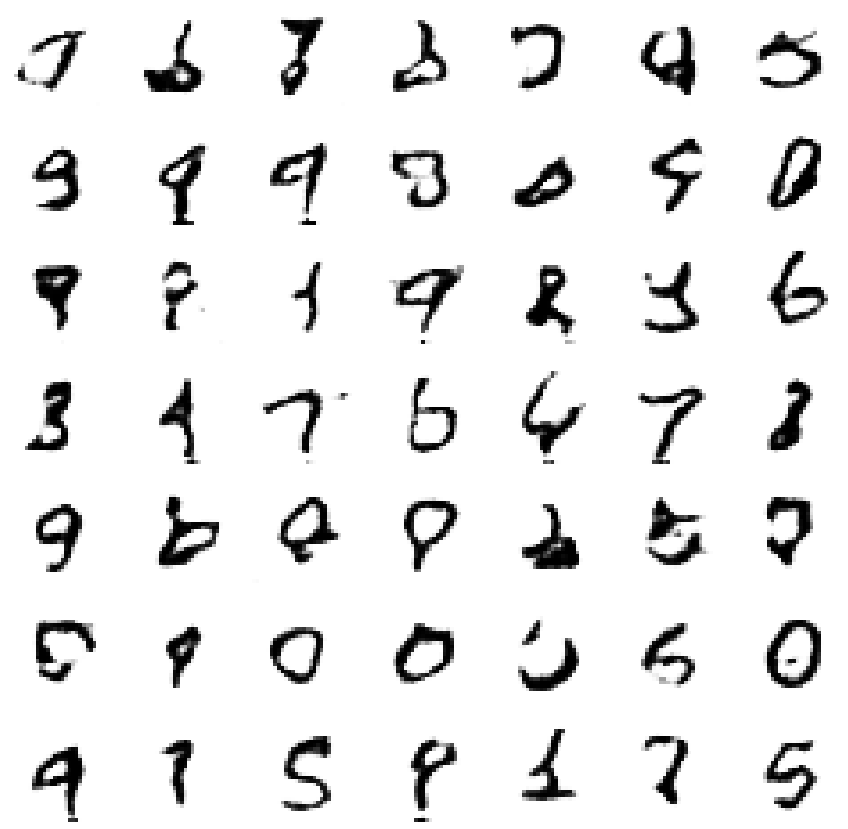

Epoch 17: Step 50/468 >> D_LOSS : 0.6373162269592285 >> G_LOSS: 0.8607050776481628
Epoch 17: Step 100/468 >> D_LOSS : 0.6462036967277527 >> G_LOSS: 0.885440468788147
Epoch 17: Step 150/468 >> D_LOSS : 0.6738735437393188 >> G_LOSS: 1.1423757076263428
Epoch 17: Step 200/468 >> D_LOSS : 0.6676346659660339 >> G_LOSS: 0.7697677612304688
Epoch 17: Step 250/468 >> D_LOSS : 0.6559121608734131 >> G_LOSS: 1.1542584896087646
Epoch 17: Step 300/468 >> D_LOSS : 0.7015295028686523 >> G_LOSS: 0.6560606956481934
Epoch 17: Step 350/468 >> D_LOSS : 0.6490243077278137 >> G_LOSS: 0.810038149356842
Epoch 17: Step 400/468 >> D_LOSS : 0.7131444215774536 >> G_LOSS: 0.9689067602157593
Epoch 17: Step 450/468 >> D_LOSS : 0.634821891784668 >> G_LOSS: 0.8578817248344421
Epoch 18: Step 50/468 >> D_LOSS : 0.6390666961669922 >> G_LOSS: 0.7424167394638062
Epoch 18: Step 100/468 >> D_LOSS : 0.6207089424133301 >> G_LOSS: 0.8536485433578491
Epoch 18: Step 150/468 >> D_LOSS : 0.638687014579773 >> G_LOSS: 0.846872031688690

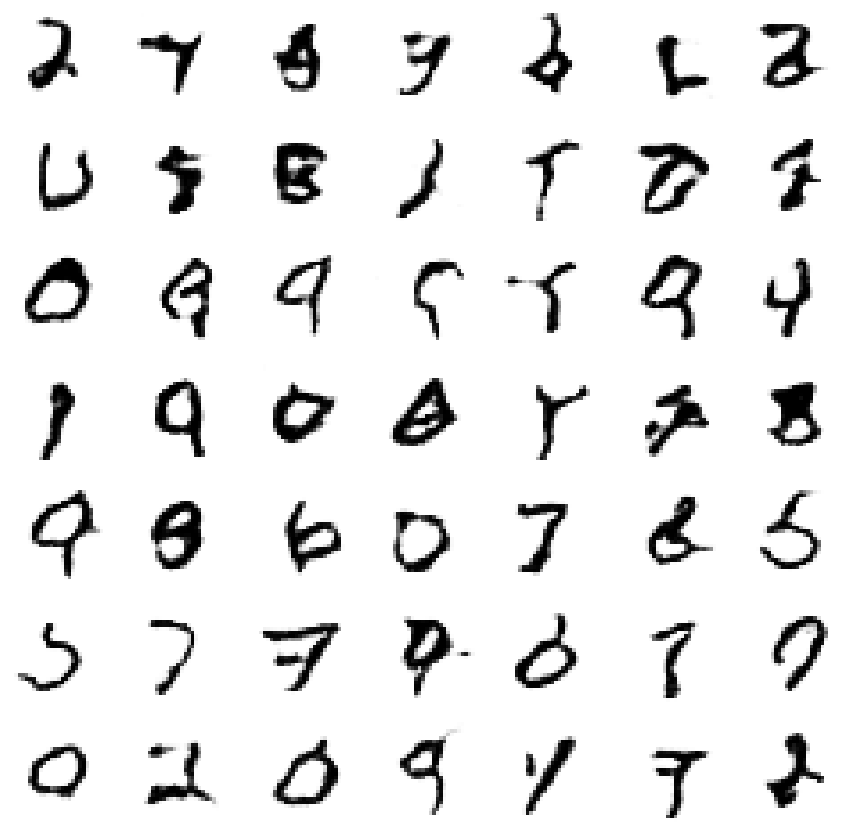

Epoch 19: Step 50/468 >> D_LOSS : 0.6471002101898193 >> G_LOSS: 0.6641618013381958
Epoch 19: Step 100/468 >> D_LOSS : 0.6561250686645508 >> G_LOSS: 0.6941827535629272
Epoch 19: Step 150/468 >> D_LOSS : 0.6574411392211914 >> G_LOSS: 0.7249501347541809
Epoch 19: Step 200/468 >> D_LOSS : 0.705159068107605 >> G_LOSS: 0.9711307287216187
Epoch 19: Step 250/468 >> D_LOSS : 0.6465624570846558 >> G_LOSS: 0.7467607855796814
Epoch 19: Step 300/468 >> D_LOSS : 0.6269181370735168 >> G_LOSS: 0.9012117981910706
Epoch 19: Step 350/468 >> D_LOSS : 0.6433799862861633 >> G_LOSS: 0.6637046337127686
Epoch 19: Step 400/468 >> D_LOSS : 0.6447315812110901 >> G_LOSS: 0.556294322013855
Epoch 19: Step 450/468 >> D_LOSS : 0.6620208024978638 >> G_LOSS: 0.7052139043807983
Epoch 20: Step 50/468 >> D_LOSS : 0.6292904019355774 >> G_LOSS: 1.0019404888153076
Epoch 20: Step 100/468 >> D_LOSS : 0.605998158454895 >> G_LOSS: 0.654559314250946
Epoch 20: Step 150/468 >> D_LOSS : 0.6472428441047668 >> G_LOSS: 1.039012432098388

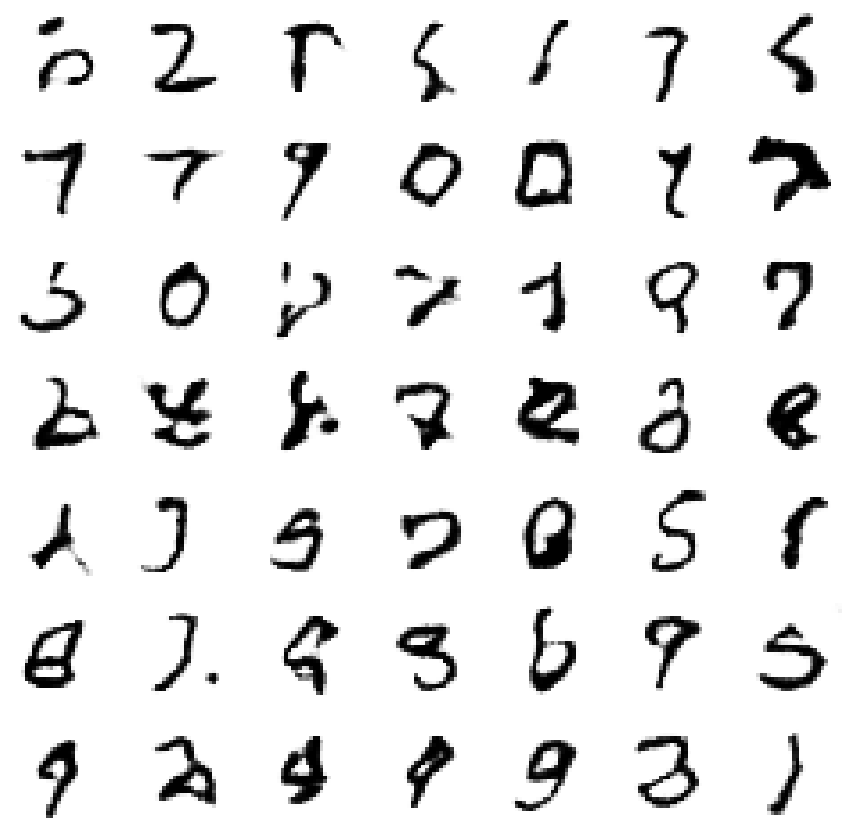

Epoch 21: Step 50/468 >> D_LOSS : 0.6639092564582825 >> G_LOSS: 0.7777761816978455
Epoch 21: Step 100/468 >> D_LOSS : 0.6750121712684631 >> G_LOSS: 0.8003989458084106
Epoch 21: Step 150/468 >> D_LOSS : 0.6381428241729736 >> G_LOSS: 0.9098135828971863
Epoch 21: Step 200/468 >> D_LOSS : 0.708562433719635 >> G_LOSS: 1.116310715675354
Epoch 21: Step 250/468 >> D_LOSS : 0.6896140575408936 >> G_LOSS: 0.8016810417175293
Epoch 21: Step 300/468 >> D_LOSS : 0.6326904296875 >> G_LOSS: 0.9077490568161011
Epoch 21: Step 350/468 >> D_LOSS : 0.6506718397140503 >> G_LOSS: 0.884661853313446
Epoch 21: Step 400/468 >> D_LOSS : 0.6848812103271484 >> G_LOSS: 0.9160674810409546
Epoch 21: Step 450/468 >> D_LOSS : 0.6465545892715454 >> G_LOSS: 0.5435351133346558
Epoch 22: Step 50/468 >> D_LOSS : 0.6941728591918945 >> G_LOSS: 0.7808141708374023
Epoch 22: Step 100/468 >> D_LOSS : 0.6556986570358276 >> G_LOSS: 0.69228595495224
Epoch 22: Step 150/468 >> D_LOSS : 0.6514303088188171 >> G_LOSS: 0.7670189738273621
Ep

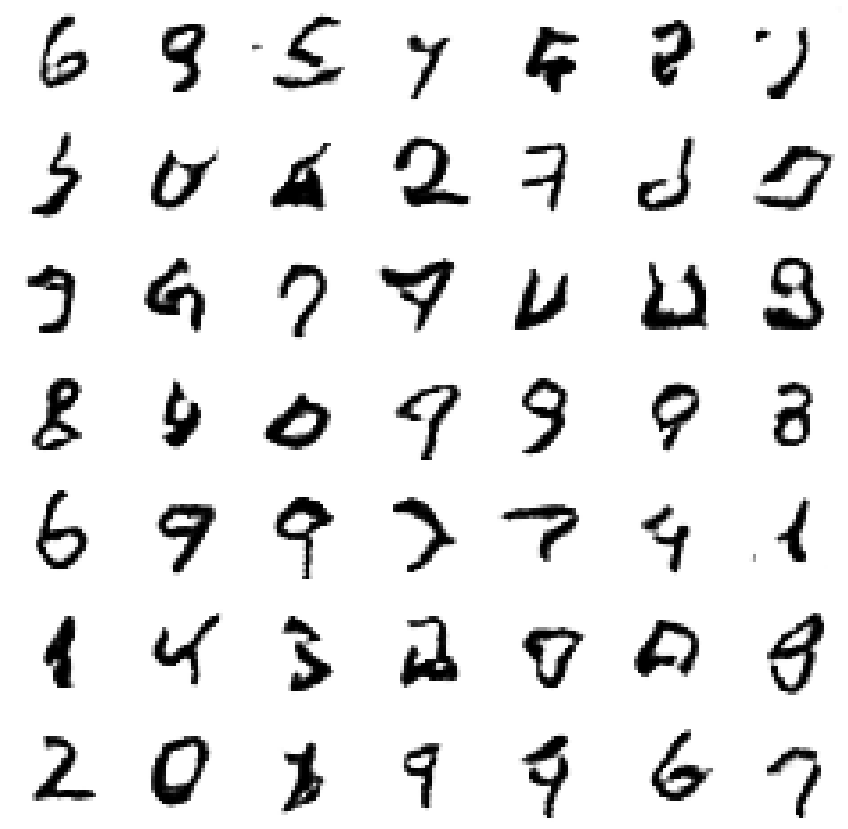

Epoch 23: Step 50/468 >> D_LOSS : 0.6478477716445923 >> G_LOSS: 0.6723762154579163
Epoch 23: Step 100/468 >> D_LOSS : 0.6434358358383179 >> G_LOSS: 0.7472072839736938
Epoch 23: Step 150/468 >> D_LOSS : 0.6250321269035339 >> G_LOSS: 0.9201878309249878
Epoch 23: Step 200/468 >> D_LOSS : 0.6570620536804199 >> G_LOSS: 0.9370481967926025
Epoch 23: Step 250/468 >> D_LOSS : 0.6328669190406799 >> G_LOSS: 0.851272702217102
Epoch 23: Step 300/468 >> D_LOSS : 0.6565186977386475 >> G_LOSS: 0.8351655006408691
Epoch 23: Step 350/468 >> D_LOSS : 0.7046825289726257 >> G_LOSS: 0.686508297920227
Epoch 23: Step 400/468 >> D_LOSS : 0.652407169342041 >> G_LOSS: 0.7314282655715942
Epoch 23: Step 450/468 >> D_LOSS : 0.667111873626709 >> G_LOSS: 0.7100227475166321
Epoch 24: Step 50/468 >> D_LOSS : 0.6567366123199463 >> G_LOSS: 0.6822680234909058
Epoch 24: Step 100/468 >> D_LOSS : 0.6390258073806763 >> G_LOSS: 0.7706112861633301
Epoch 24: Step 150/468 >> D_LOSS : 0.6444161534309387 >> G_LOSS: 0.981606185436248

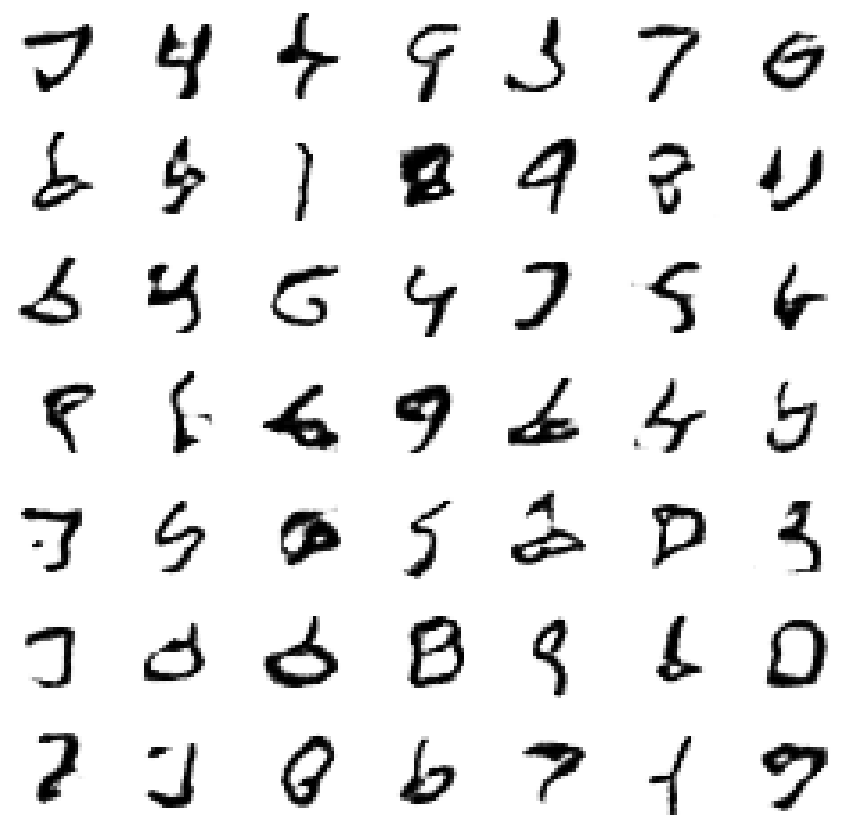

Epoch 25: Step 50/468 >> D_LOSS : 0.649895966053009 >> G_LOSS: 0.8375731706619263
Epoch 25: Step 100/468 >> D_LOSS : 0.6755168437957764 >> G_LOSS: 0.8421593904495239
Epoch 25: Step 150/468 >> D_LOSS : 0.6731976270675659 >> G_LOSS: 0.7223117351531982
Epoch 25: Step 200/468 >> D_LOSS : 0.7028795480728149 >> G_LOSS: 0.6324195861816406
Epoch 25: Step 250/468 >> D_LOSS : 0.6754310727119446 >> G_LOSS: 0.9949934482574463
Epoch 25: Step 300/468 >> D_LOSS : 0.68290114402771 >> G_LOSS: 0.8692980408668518
Epoch 25: Step 350/468 >> D_LOSS : 0.6651740670204163 >> G_LOSS: 1.0760142803192139
Epoch 25: Step 400/468 >> D_LOSS : 0.6728565096855164 >> G_LOSS: 0.610770583152771
Epoch 25: Step 450/468 >> D_LOSS : 0.6647538542747498 >> G_LOSS: 0.8366070985794067
Epoch 26: Step 50/468 >> D_LOSS : 0.6527003049850464 >> G_LOSS: 0.7189195156097412
Epoch 26: Step 100/468 >> D_LOSS : 0.5978373885154724 >> G_LOSS: 0.983344316482544
Epoch 26: Step 150/468 >> D_LOSS : 0.666359543800354 >> G_LOSS: 0.9209890365600586


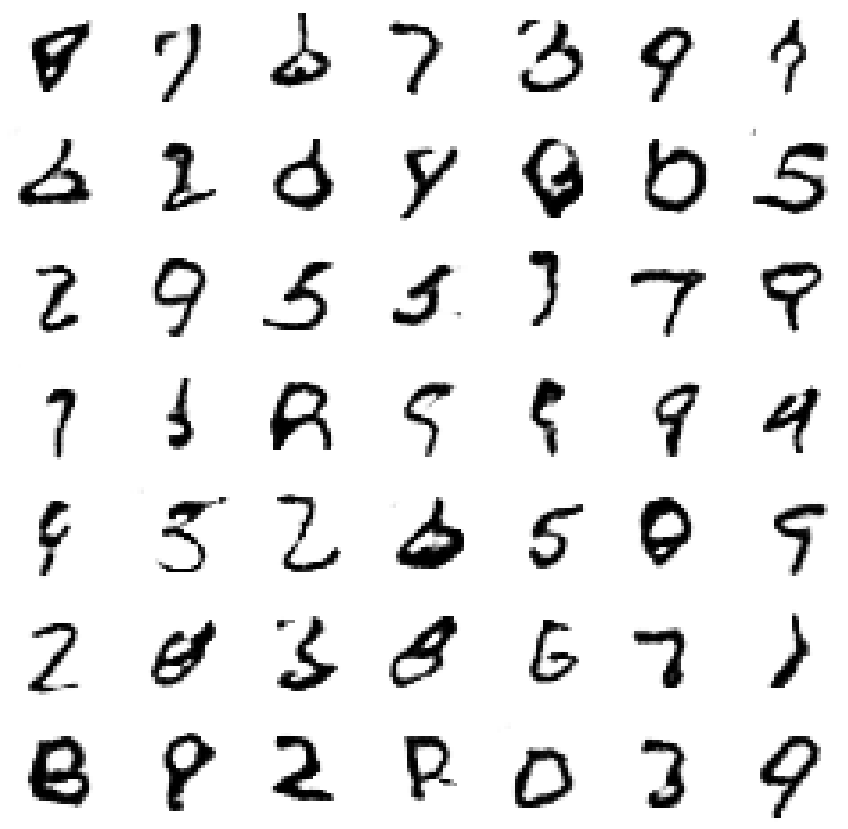

Epoch 27: Step 50/468 >> D_LOSS : 0.6659027338027954 >> G_LOSS: 0.6762101650238037
Epoch 27: Step 100/468 >> D_LOSS : 0.7016408443450928 >> G_LOSS: 0.6532758474349976
Epoch 27: Step 150/468 >> D_LOSS : 0.6558295488357544 >> G_LOSS: 0.7723222970962524
Epoch 27: Step 200/468 >> D_LOSS : 0.6630654335021973 >> G_LOSS: 0.6587800979614258
Epoch 27: Step 250/468 >> D_LOSS : 0.6522403955459595 >> G_LOSS: 0.8594440221786499
Epoch 27: Step 300/468 >> D_LOSS : 0.6643632650375366 >> G_LOSS: 0.7266993522644043
Epoch 27: Step 350/468 >> D_LOSS : 0.6970592141151428 >> G_LOSS: 0.6767539381980896
Epoch 27: Step 400/468 >> D_LOSS : 0.6208850145339966 >> G_LOSS: 0.6155394315719604
Epoch 27: Step 450/468 >> D_LOSS : 0.6471359729766846 >> G_LOSS: 0.7347671985626221
Epoch 28: Step 50/468 >> D_LOSS : 0.6541399955749512 >> G_LOSS: 0.6492597460746765
Epoch 28: Step 100/468 >> D_LOSS : 0.666721761226654 >> G_LOSS: 0.8105109930038452
Epoch 28: Step 150/468 >> D_LOSS : 0.6345155835151672 >> G_LOSS: 0.860585808753

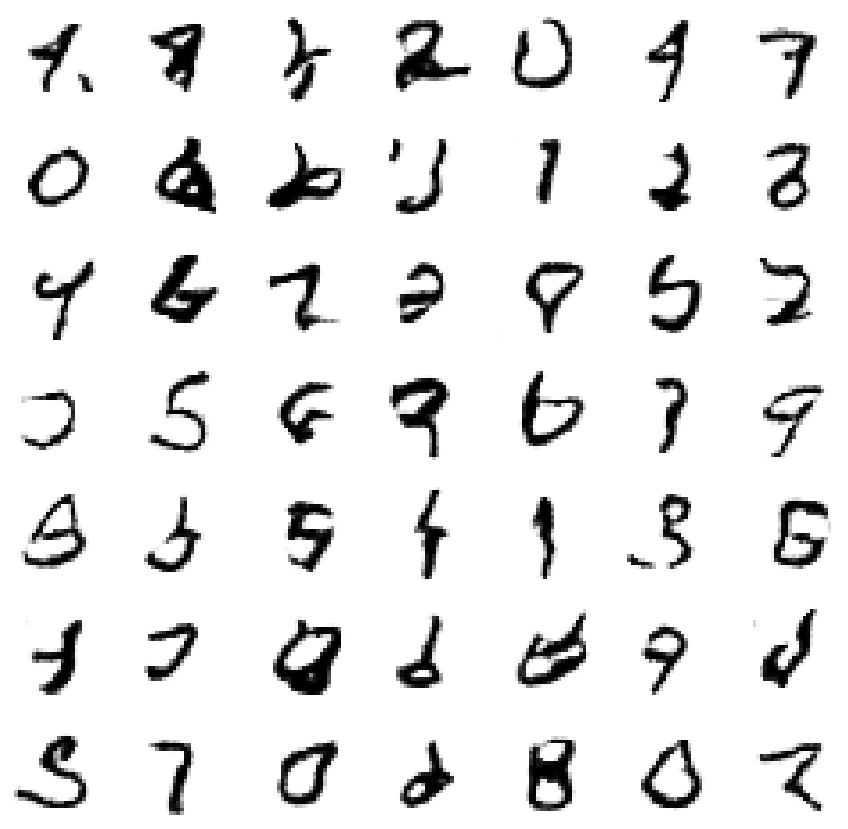

Epoch 29: Step 50/468 >> D_LOSS : 0.6459094882011414 >> G_LOSS: 0.6640303134918213
Epoch 29: Step 100/468 >> D_LOSS : 0.6430083513259888 >> G_LOSS: 0.6217566132545471
Epoch 29: Step 150/468 >> D_LOSS : 0.6950314044952393 >> G_LOSS: 0.6767191886901855
Epoch 29: Step 200/468 >> D_LOSS : 0.6615261435508728 >> G_LOSS: 0.8670563697814941
Epoch 29: Step 250/468 >> D_LOSS : 0.6841288208961487 >> G_LOSS: 1.1153885126113892
Epoch 29: Step 300/468 >> D_LOSS : 0.648166298866272 >> G_LOSS: 0.6877927780151367
Epoch 29: Step 350/468 >> D_LOSS : 0.6437534093856812 >> G_LOSS: 0.978745698928833
Epoch 29: Step 400/468 >> D_LOSS : 0.6518397331237793 >> G_LOSS: 0.757127046585083
Epoch 29: Step 450/468 >> D_LOSS : 0.6510244607925415 >> G_LOSS: 0.8697941303253174
Epoch 30: Step 50/468 >> D_LOSS : 0.7105396389961243 >> G_LOSS: 0.8891682624816895
Epoch 30: Step 100/468 >> D_LOSS : 0.663122296333313 >> G_LOSS: 0.6834191679954529
Epoch 30: Step 150/468 >> D_LOSS : 0.6840365529060364 >> G_LOSS: 0.807853817939758

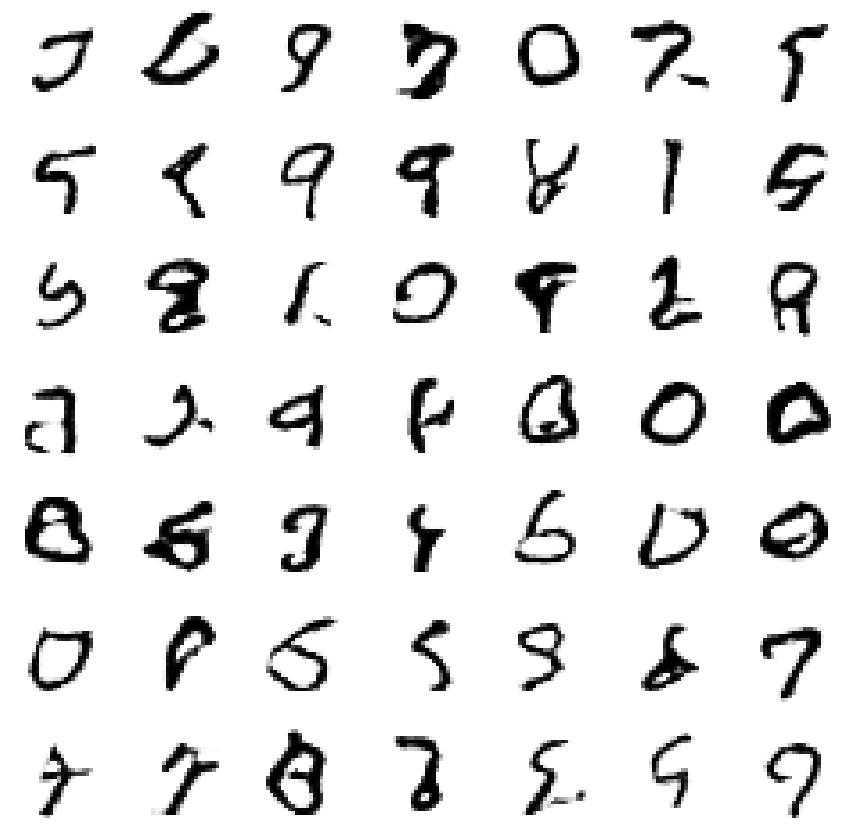

Epoch 31: Step 50/468 >> D_LOSS : 0.6914999485015869 >> G_LOSS: 0.7764756679534912
Epoch 31: Step 100/468 >> D_LOSS : 0.676285982131958 >> G_LOSS: 0.7923129200935364
Epoch 31: Step 150/468 >> D_LOSS : 0.6571865081787109 >> G_LOSS: 0.7822138071060181
Epoch 31: Step 200/468 >> D_LOSS : 0.6610078811645508 >> G_LOSS: 0.9635650515556335
Epoch 31: Step 250/468 >> D_LOSS : 0.6476000547409058 >> G_LOSS: 1.0701050758361816
Epoch 31: Step 300/468 >> D_LOSS : 0.7014477252960205 >> G_LOSS: 0.852030873298645
Epoch 31: Step 350/468 >> D_LOSS : 0.6984868049621582 >> G_LOSS: 0.5853750705718994
Epoch 31: Step 400/468 >> D_LOSS : 0.6548502445220947 >> G_LOSS: 0.6327059268951416
Epoch 31: Step 450/468 >> D_LOSS : 0.64650559425354 >> G_LOSS: 0.538928747177124
Epoch 32: Step 50/468 >> D_LOSS : 0.6848047375679016 >> G_LOSS: 0.675389289855957
Epoch 32: Step 100/468 >> D_LOSS : 0.693997859954834 >> G_LOSS: 0.8589870929718018
Epoch 32: Step 150/468 >> D_LOSS : 0.6711969375610352 >> G_LOSS: 0.7031991481781006
E

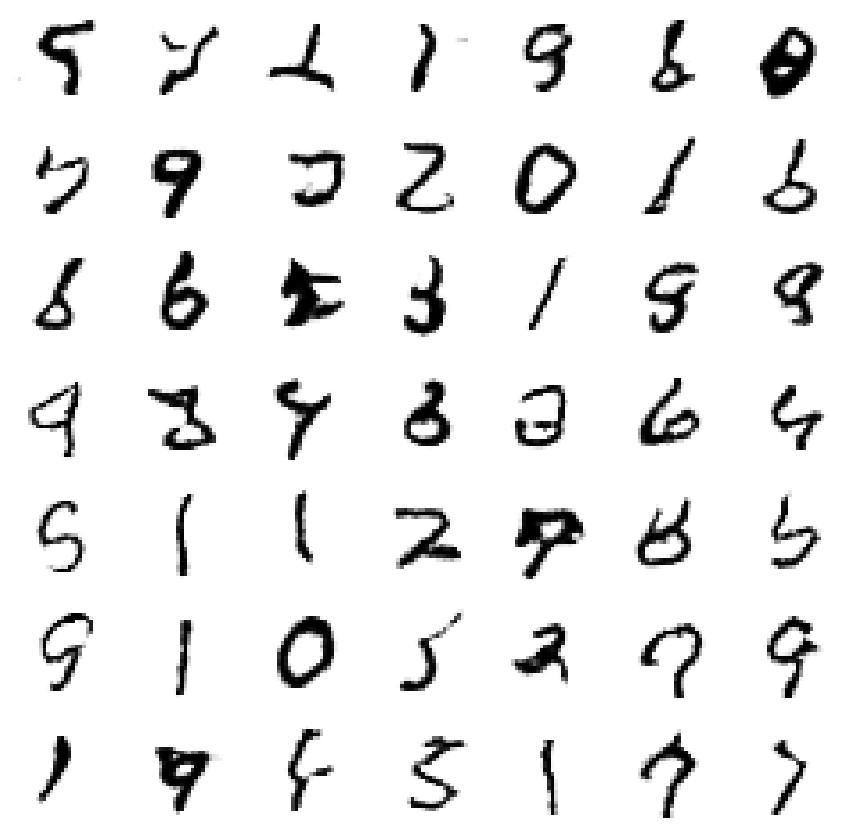

Epoch 33: Step 50/468 >> D_LOSS : 0.6644278764724731 >> G_LOSS: 0.8223912715911865
Epoch 33: Step 100/468 >> D_LOSS : 0.6550388336181641 >> G_LOSS: 1.030808925628662
Epoch 33: Step 150/468 >> D_LOSS : 0.6796236634254456 >> G_LOSS: 0.5854669809341431
Epoch 33: Step 200/468 >> D_LOSS : 0.6616645455360413 >> G_LOSS: 0.5728725790977478
Epoch 33: Step 250/468 >> D_LOSS : 0.6700049042701721 >> G_LOSS: 0.8351143598556519
Epoch 33: Step 300/468 >> D_LOSS : 0.6795320510864258 >> G_LOSS: 0.6426172256469727
Epoch 33: Step 350/468 >> D_LOSS : 0.6685230731964111 >> G_LOSS: 0.7722835540771484
Epoch 33: Step 400/468 >> D_LOSS : 0.6793251037597656 >> G_LOSS: 0.6152106523513794
Epoch 33: Step 450/468 >> D_LOSS : 0.6517086029052734 >> G_LOSS: 0.8923922777175903
Epoch 34: Step 50/468 >> D_LOSS : 0.6875274181365967 >> G_LOSS: 0.6292402744293213
Epoch 34: Step 100/468 >> D_LOSS : 0.673884391784668 >> G_LOSS: 0.9238120317459106
Epoch 34: Step 150/468 >> D_LOSS : 0.6798995733261108 >> G_LOSS: 0.6572005748748

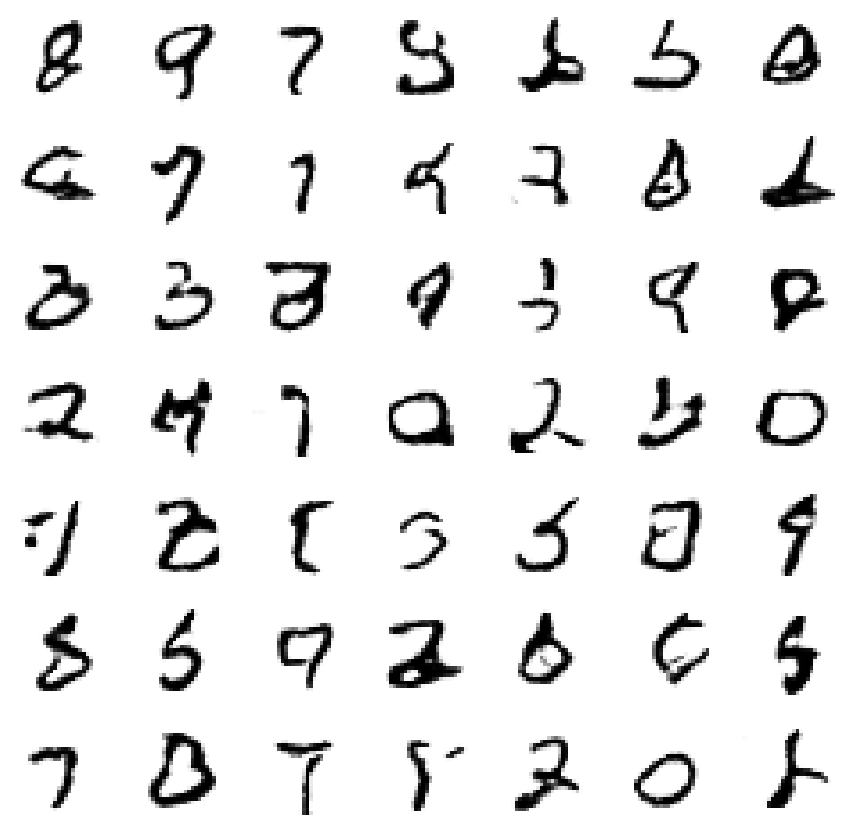

Epoch 35: Step 50/468 >> D_LOSS : 0.6368152499198914 >> G_LOSS: 0.8020786046981812
Epoch 35: Step 100/468 >> D_LOSS : 0.6575531959533691 >> G_LOSS: 0.714004635810852
Epoch 35: Step 150/468 >> D_LOSS : 0.653850793838501 >> G_LOSS: 0.9105802774429321
Epoch 35: Step 200/468 >> D_LOSS : 0.6769440770149231 >> G_LOSS: 0.9458091259002686
Epoch 35: Step 250/468 >> D_LOSS : 0.6407622694969177 >> G_LOSS: 0.5872002243995667
Epoch 35: Step 300/468 >> D_LOSS : 0.6990923881530762 >> G_LOSS: 0.9831838607788086
Epoch 35: Step 350/468 >> D_LOSS : 0.6760046482086182 >> G_LOSS: 0.7816348075866699
Epoch 35: Step 400/468 >> D_LOSS : 0.7093239426612854 >> G_LOSS: 0.6859829425811768
Epoch 35: Step 450/468 >> D_LOSS : 0.6147091388702393 >> G_LOSS: 0.679758608341217
Epoch 36: Step 50/468 >> D_LOSS : 0.677675724029541 >> G_LOSS: 0.6325769424438477
Epoch 36: Step 100/468 >> D_LOSS : 0.6883780360221863 >> G_LOSS: 0.801530659198761
Epoch 36: Step 150/468 >> D_LOSS : 0.6530600786209106 >> G_LOSS: 0.9658477306365967

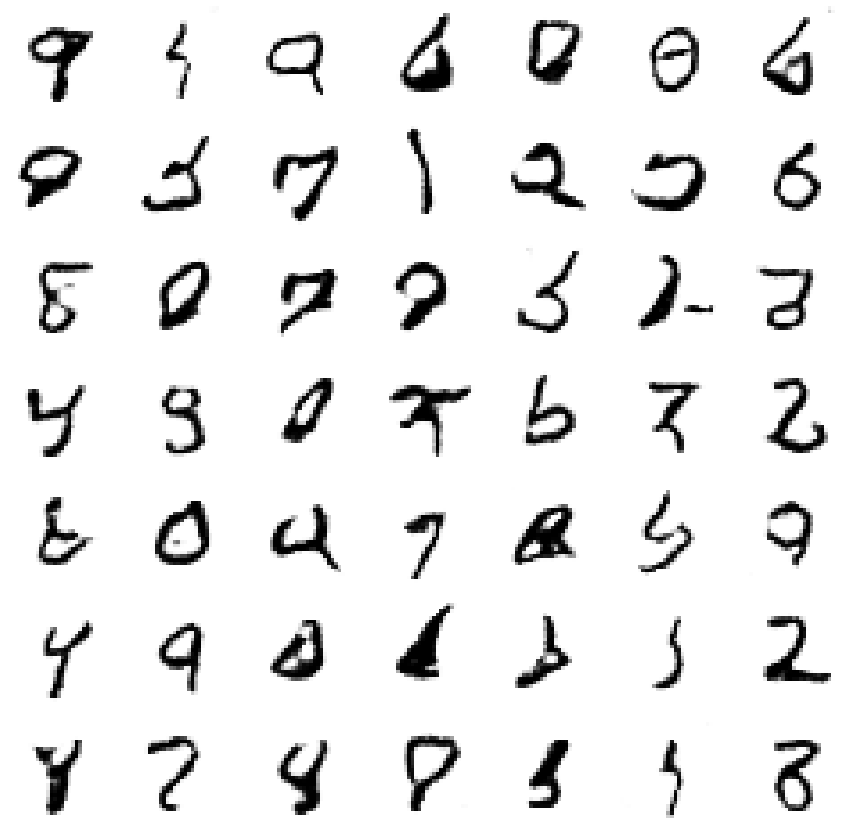

Epoch 37: Step 50/468 >> D_LOSS : 0.7000732421875 >> G_LOSS: 0.598028838634491
Epoch 37: Step 100/468 >> D_LOSS : 0.6337321996688843 >> G_LOSS: 0.9217849969863892
Epoch 37: Step 150/468 >> D_LOSS : 0.6827802658081055 >> G_LOSS: 0.6102975606918335
Epoch 37: Step 200/468 >> D_LOSS : 0.6481468677520752 >> G_LOSS: 0.8426281213760376
Epoch 37: Step 250/468 >> D_LOSS : 0.6749117970466614 >> G_LOSS: 1.0038148164749146
Epoch 37: Step 300/468 >> D_LOSS : 0.6566470861434937 >> G_LOSS: 0.8078601360321045
Epoch 37: Step 350/468 >> D_LOSS : 0.7109485864639282 >> G_LOSS: 0.6590028405189514
Epoch 37: Step 400/468 >> D_LOSS : 0.6483640074729919 >> G_LOSS: 0.8814963102340698
Epoch 37: Step 450/468 >> D_LOSS : 0.7067192196846008 >> G_LOSS: 0.8665511012077332
Epoch 38: Step 50/468 >> D_LOSS : 0.6698864102363586 >> G_LOSS: 0.8118217587471008
Epoch 38: Step 100/468 >> D_LOSS : 0.6832917928695679 >> G_LOSS: 0.8211040496826172
Epoch 38: Step 150/468 >> D_LOSS : 0.6607071161270142 >> G_LOSS: 0.930025160312652

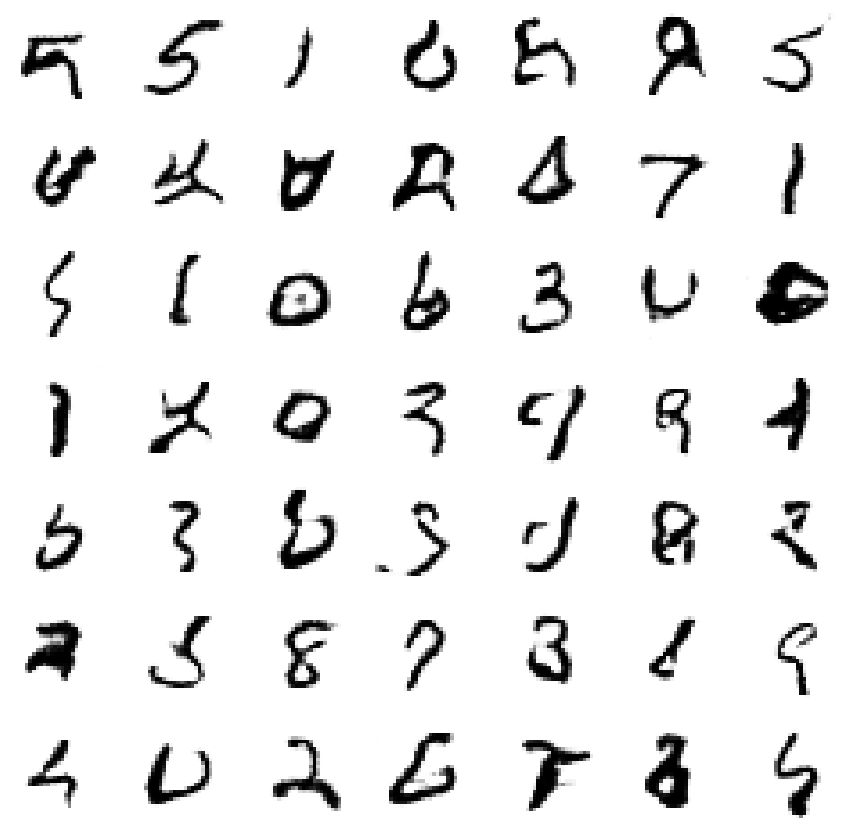

Epoch 39: Step 50/468 >> D_LOSS : 0.6756536960601807 >> G_LOSS: 0.6553044319152832
Epoch 39: Step 100/468 >> D_LOSS : 0.6551254391670227 >> G_LOSS: 0.7978041768074036
Epoch 39: Step 150/468 >> D_LOSS : 0.6612790822982788 >> G_LOSS: 0.8332631587982178
Epoch 39: Step 200/468 >> D_LOSS : 0.6740248799324036 >> G_LOSS: 0.9214327931404114
Epoch 39: Step 250/468 >> D_LOSS : 0.6668651103973389 >> G_LOSS: 0.8665119409561157
Epoch 39: Step 300/468 >> D_LOSS : 0.6957316398620605 >> G_LOSS: 0.8575531244277954
Epoch 39: Step 350/468 >> D_LOSS : 0.6727097630500793 >> G_LOSS: 0.6286704540252686
Epoch 39: Step 400/468 >> D_LOSS : 0.6485866904258728 >> G_LOSS: 0.6993224620819092
Epoch 39: Step 450/468 >> D_LOSS : 0.672109842300415 >> G_LOSS: 0.945107638835907
Epoch 40: Step 50/468 >> D_LOSS : 0.66466224193573 >> G_LOSS: 0.8635914325714111
Epoch 40: Step 100/468 >> D_LOSS : 0.6769139170646667 >> G_LOSS: 0.8131749033927917
Epoch 40: Step 150/468 >> D_LOSS : 0.6765143871307373 >> G_LOSS: 0.688057899475097

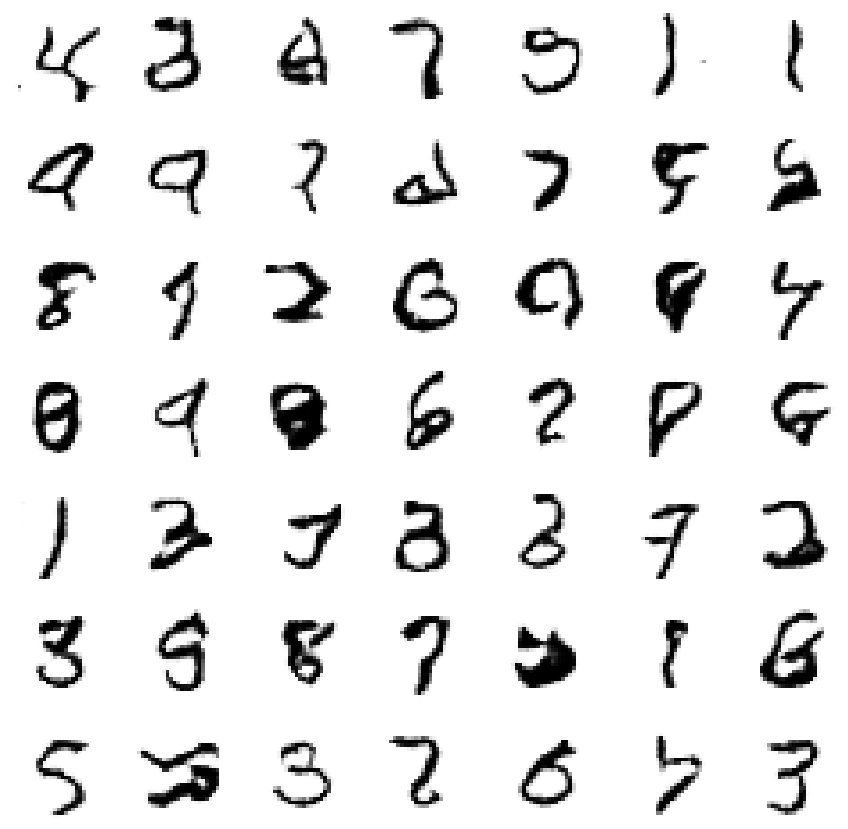

Epoch 41: Step 50/468 >> D_LOSS : 0.6533267498016357 >> G_LOSS: 0.682518720626831
Epoch 41: Step 100/468 >> D_LOSS : 0.6766709685325623 >> G_LOSS: 0.8104827404022217
Epoch 41: Step 150/468 >> D_LOSS : 0.683695912361145 >> G_LOSS: 0.8546480536460876
Epoch 41: Step 200/468 >> D_LOSS : 0.6847177743911743 >> G_LOSS: 0.8179820775985718
Epoch 41: Step 250/468 >> D_LOSS : 0.6117211580276489 >> G_LOSS: 0.6157965660095215
Epoch 41: Step 300/468 >> D_LOSS : 0.6544638872146606 >> G_LOSS: 0.8244378566741943
Epoch 41: Step 350/468 >> D_LOSS : 0.6791896820068359 >> G_LOSS: 0.7320171594619751
Epoch 41: Step 400/468 >> D_LOSS : 0.6792458295822144 >> G_LOSS: 0.9350536465644836
Epoch 41: Step 450/468 >> D_LOSS : 0.654411792755127 >> G_LOSS: 0.7092512845993042
Epoch 42: Step 50/468 >> D_LOSS : 0.688793420791626 >> G_LOSS: 0.7703759670257568
Epoch 42: Step 100/468 >> D_LOSS : 0.6751675605773926 >> G_LOSS: 0.702728807926178
Epoch 42: Step 150/468 >> D_LOSS : 0.6781376004219055 >> G_LOSS: 0.7683092355728149

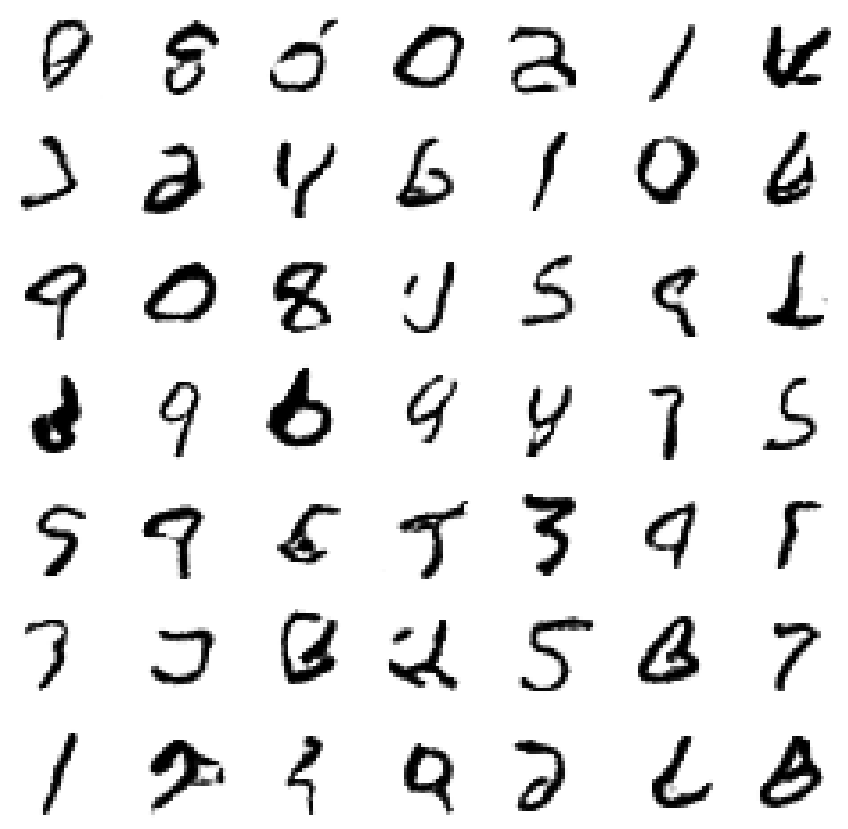

Epoch 43: Step 50/468 >> D_LOSS : 0.6575931906700134 >> G_LOSS: 0.6964858770370483
Epoch 43: Step 100/468 >> D_LOSS : 0.6698588728904724 >> G_LOSS: 0.7000465393066406
Epoch 43: Step 150/468 >> D_LOSS : 0.6796005964279175 >> G_LOSS: 0.5757204294204712
Epoch 43: Step 200/468 >> D_LOSS : 0.6825529336929321 >> G_LOSS: 0.8042063117027283
Epoch 43: Step 250/468 >> D_LOSS : 0.6950029730796814 >> G_LOSS: 0.5251147150993347
Epoch 43: Step 300/468 >> D_LOSS : 0.6763366460800171 >> G_LOSS: 0.8460271954536438
Epoch 43: Step 350/468 >> D_LOSS : 0.6761702299118042 >> G_LOSS: 0.9661133289337158
Epoch 43: Step 400/468 >> D_LOSS : 0.6559919118881226 >> G_LOSS: 1.038284420967102
Epoch 43: Step 450/468 >> D_LOSS : 0.6577603220939636 >> G_LOSS: 0.7845381498336792
Epoch 44: Step 50/468 >> D_LOSS : 0.7001116275787354 >> G_LOSS: 0.6424916982650757
Epoch 44: Step 100/468 >> D_LOSS : 0.6705368757247925 >> G_LOSS: 0.8792133927345276
Epoch 44: Step 150/468 >> D_LOSS : 0.6897521018981934 >> G_LOSS: 0.531841516494

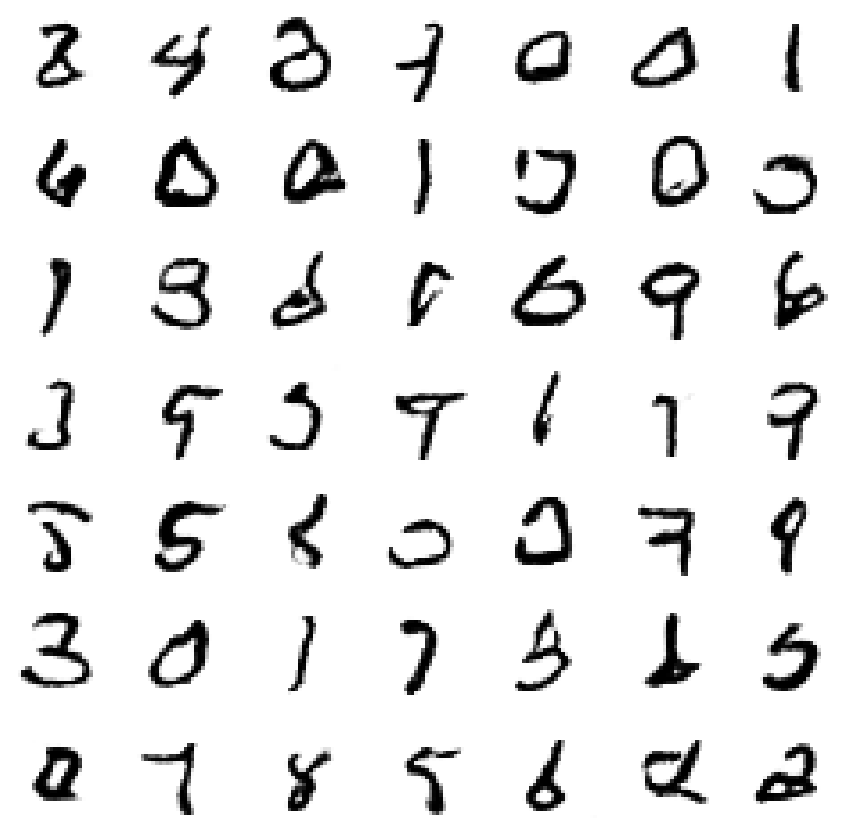

Epoch 45: Step 50/468 >> D_LOSS : 0.6626226305961609 >> G_LOSS: 0.8829279541969299
Epoch 45: Step 100/468 >> D_LOSS : 0.678734302520752 >> G_LOSS: 0.9793803691864014
Epoch 45: Step 150/468 >> D_LOSS : 0.6710187196731567 >> G_LOSS: 0.7569684386253357
Epoch 45: Step 200/468 >> D_LOSS : 0.6641509532928467 >> G_LOSS: 0.837787389755249
Epoch 45: Step 250/468 >> D_LOSS : 0.6632645130157471 >> G_LOSS: 0.700721263885498
Epoch 45: Step 300/468 >> D_LOSS : 0.6831053495407104 >> G_LOSS: 0.6805131435394287
Epoch 45: Step 350/468 >> D_LOSS : 0.6808509826660156 >> G_LOSS: 0.6739729642868042
Epoch 45: Step 400/468 >> D_LOSS : 0.6951920986175537 >> G_LOSS: 0.683188796043396
Epoch 45: Step 450/468 >> D_LOSS : 0.6636945605278015 >> G_LOSS: 0.9499408006668091
Epoch 46: Step 50/468 >> D_LOSS : 0.6914946436882019 >> G_LOSS: 0.843420147895813
Epoch 46: Step 100/468 >> D_LOSS : 0.6692230701446533 >> G_LOSS: 0.7098226547241211
Epoch 46: Step 150/468 >> D_LOSS : 0.6701610088348389 >> G_LOSS: 0.7024176120758057

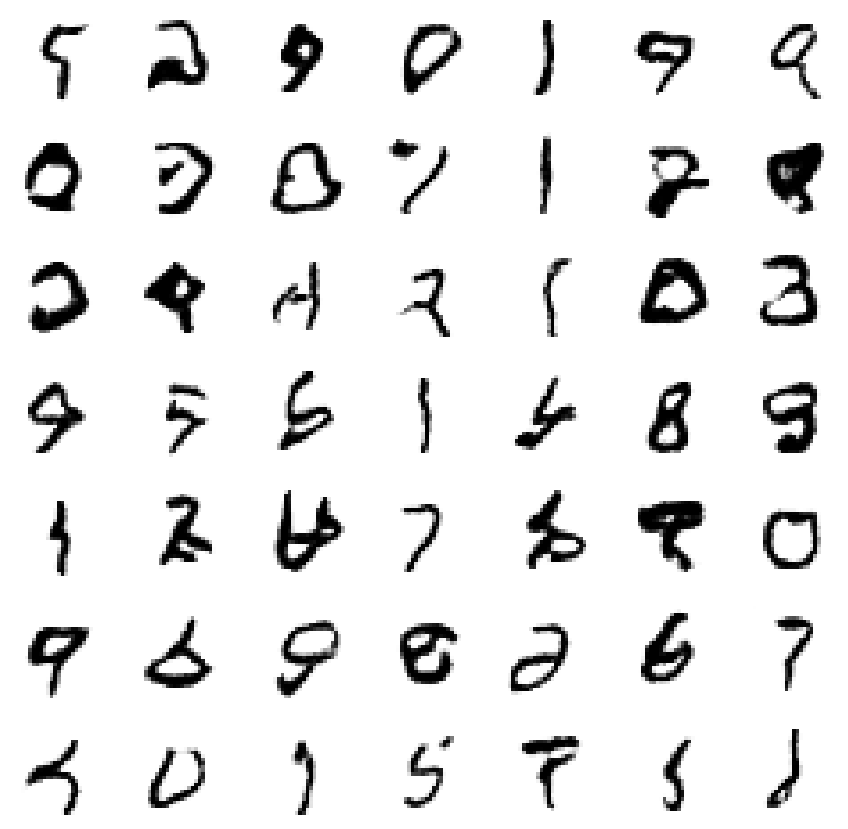

Epoch 47: Step 50/468 >> D_LOSS : 0.6658485531806946 >> G_LOSS: 0.9648748636245728
Epoch 47: Step 100/468 >> D_LOSS : 0.7024991512298584 >> G_LOSS: 0.6650115847587585
Epoch 47: Step 150/468 >> D_LOSS : 0.689157247543335 >> G_LOSS: 0.7425095438957214
Epoch 47: Step 200/468 >> D_LOSS : 0.6554540395736694 >> G_LOSS: 0.6209256052970886
Epoch 47: Step 250/468 >> D_LOSS : 0.6660339832305908 >> G_LOSS: 0.7218536138534546
Epoch 47: Step 300/468 >> D_LOSS : 0.680156409740448 >> G_LOSS: 0.7258810997009277
Epoch 47: Step 350/468 >> D_LOSS : 0.6944007873535156 >> G_LOSS: 0.7369881868362427
Epoch 47: Step 400/468 >> D_LOSS : 0.690395712852478 >> G_LOSS: 0.8557988405227661
Epoch 47: Step 450/468 >> D_LOSS : 0.6834145188331604 >> G_LOSS: 0.9110265970230103
Epoch 48: Step 50/468 >> D_LOSS : 0.6817370057106018 >> G_LOSS: 0.919356107711792
Epoch 48: Step 100/468 >> D_LOSS : 0.6592909693717957 >> G_LOSS: 0.7119081020355225
Epoch 48: Step 150/468 >> D_LOSS : 0.6704137325286865 >> G_LOSS: 0.590417444705963

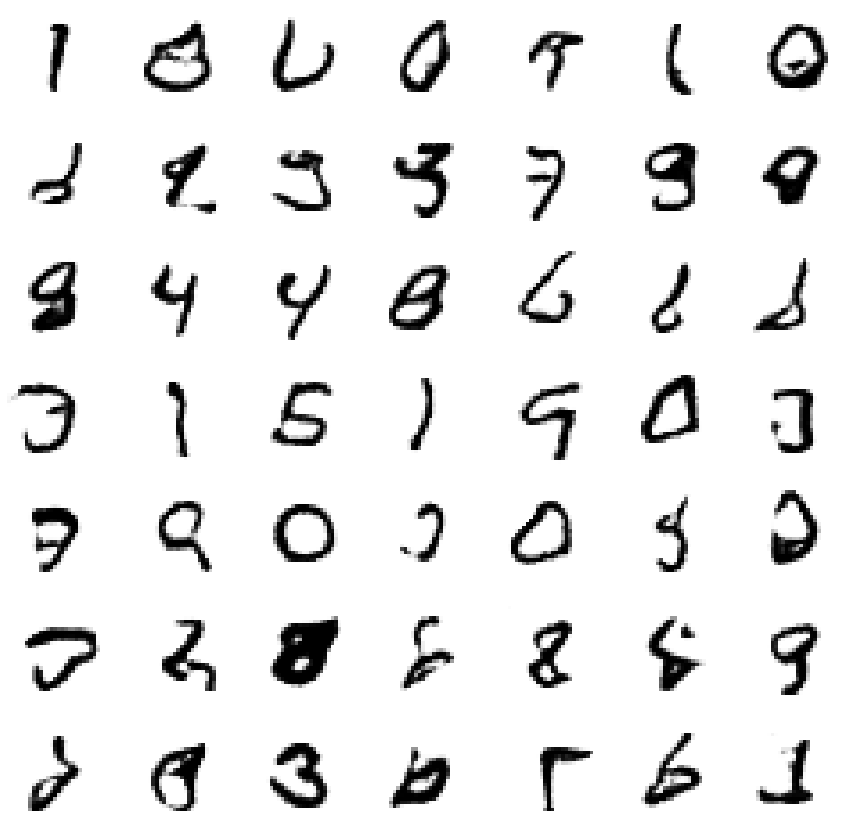

Epoch 49: Step 50/468 >> D_LOSS : 0.6682149171829224 >> G_LOSS: 0.8824663162231445
Epoch 49: Step 100/468 >> D_LOSS : 0.6778008937835693 >> G_LOSS: 0.8889294266700745
Epoch 49: Step 150/468 >> D_LOSS : 0.6906386017799377 >> G_LOSS: 0.808425784111023
Epoch 49: Step 200/468 >> D_LOSS : 0.7050002217292786 >> G_LOSS: 0.7179306745529175
Epoch 49: Step 250/468 >> D_LOSS : 0.671277642250061 >> G_LOSS: 0.5844534039497375
Epoch 49: Step 300/468 >> D_LOSS : 0.6545851230621338 >> G_LOSS: 0.6596825122833252
Epoch 49: Step 350/468 >> D_LOSS : 0.6672449707984924 >> G_LOSS: 0.6949783563613892
Epoch 49: Step 400/468 >> D_LOSS : 0.6647811532020569 >> G_LOSS: 0.9501033425331116
Epoch 49: Step 450/468 >> D_LOSS : 0.6485368013381958 >> G_LOSS: 0.7463062405586243
Epoch 50: Step 50/468 >> D_LOSS : 0.6879372000694275 >> G_LOSS: 0.7474357485771179
Epoch 50: Step 100/468 >> D_LOSS : 0.7024883031845093 >> G_LOSS: 0.7971858382225037
Epoch 50: Step 150/468 >> D_LOSS : 0.7131714224815369 >> G_LOSS: 0.6985110044479

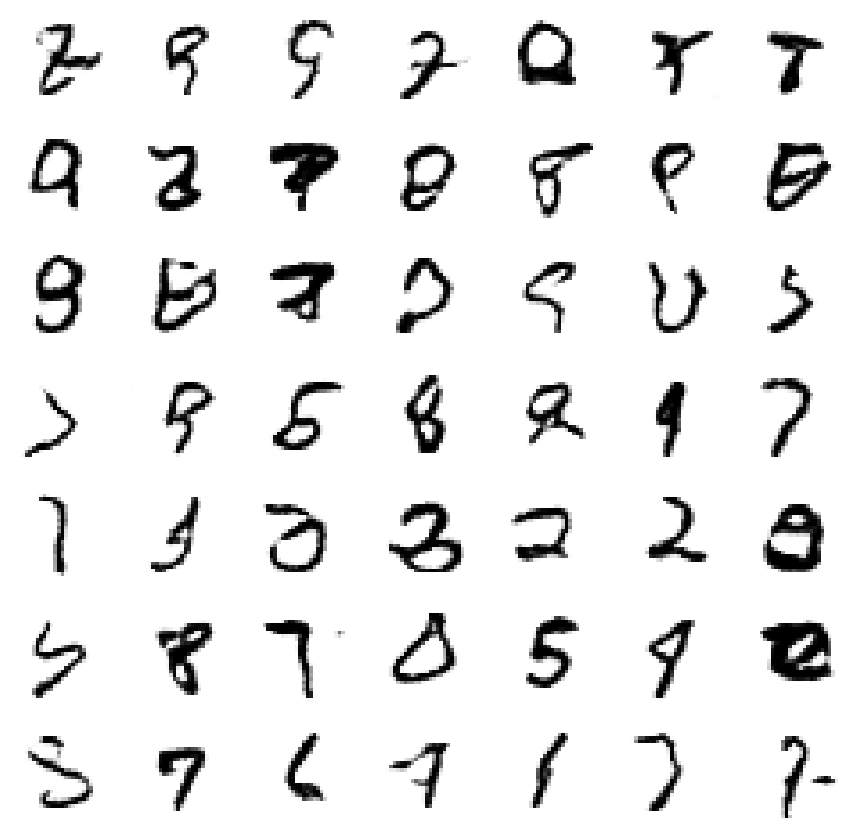

In [48]:
train_gan(d_model, g_model, gan_model, dataset, 128)